In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy = True

# Exercise 5: 
**create an image which histogram follows the equation $$ P_r(r) = \frac{2r}{(L-1)^2}  \;\;\;\;{0 \leq r \leq 255}$$Then try to flatten the histogram**

**lets First create the array that will store our histogram value **

In [2]:
#histogram = np.zeros(256, dtype = float)
l =256
histogram = [0] * l
for i in range(l):
    histogram[i] = (2 * i) / (l ** 2)

The histogram values should be multiplied by the number of image pixels (256 * 256) to represent number of pixels in each color intensity instead of probabilistic values.

In [3]:
for i in range(256):
    histogram[i] = [int(histogram[i] * 256 * 256) + 1, i]

`image` will hold the pixel values for our image

In [4]:
image = np.zeros((256, 256), dtype = int)
print(np.shape(histogram))

(256, 2)


** in this section well be randomly sampling values from the histogram and putting them in our image **

In [5]:
for i in range(256):
    for j in range(256):
        index = np.random.randint(0, high=len(histogram))
        image[i, j] = histogram[index][1]
        histogram[index][0] -= 1
        if histogram[index][0] == 0:
            histogram.pop(index)

** lets plot our generated image and see what it looks like **

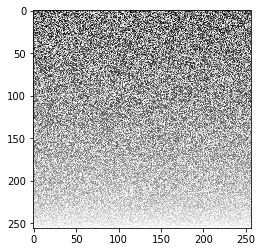

[]


In [6]:
plt.imshow(image, cmap = 'gray')
plt.show()
print(histogram)

** these two funcions will help us create our histogram and plot the values **

In [7]:
def create_histogram(img1):
    histogram = [0] * 256
    height, width = np.shape(img1)
    for h in range(height):
        for w in range(width):
            histogram[img1[h][w]] += (1 / (height * width))
    return histogram

def plot_histogram(histogram):
    plt.title("histogram of the image")
    plt.xlabel("color intensity")
    plt.ylabel("probability mass")
    plt.plot(range(256), histogram)
    plt.show()

** Ive plotted the histogram of my generated image to make sure that the values were correctly sampled from the histogram. The histogram seems to be completely linear and the histogram equation is satisfied **

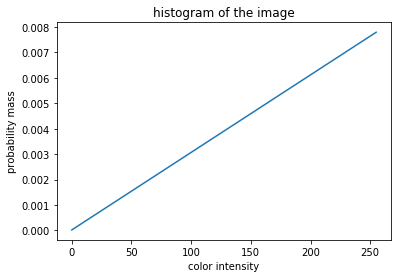

In [8]:
hist = create_histogram(image)
plot_histogram(hist)

** Lets use a simple histogram flattening method to smoothen the histogram of this generated image based on its own pixel value compared to its neighbours pixel values.**

In [9]:
for i in range(1, 255):
    for j in range(1, 255):
        center_pixel = image[i, j]
        for x in range(-1, 2):
            for y in range(-1, 2):
                if x== 0 and y == 0:
                    continue
                neighbour = image[i + x, j + y]
                if hist[center_pixel] < 256:
                    image[i + x, j + y] = center_pixel
                    hist[center_pixel]+=1
                    hist[neighbour] -= 1
                elif hist[center_pixel] > 256:
                    image[i, j] = neighbour
                    hist[neighbour] += 1
                    hist[center_pixel] -= 1

** The histogram hasnt completely smoothed out but there are signs of smoothening in the histogram, and in the image.
the plot shows that neighbouring values in the image have become very similar to each other. **

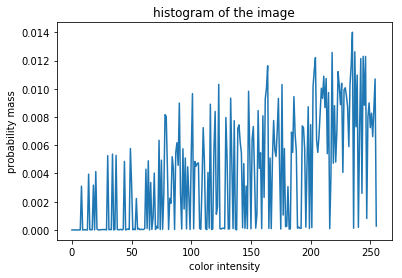

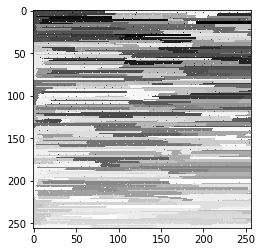

In [10]:
hist = create_histogram(image)
plot_histogram(hist)
plt.imshow(image, cmap = 'gray')
plt.show()

# Exercise 6

** In this exercise well be implementing a simple histogram equalization function and perform it on the inverse of the data provided in slide 30 of the course.
The data is as follows ** <br>

|  $r_k$ | $n_k$ | &nbsp; &nbsp; &nbsp; &nbsp; $p_r(r_k)$ |
| -----  | ----- | -------------------------|
| $0$ | $790$   | $0.19$ |
| $1$ | $1023$   | $0.25$ |
| $2$ | $850$   | $0.21$ |
| $3$ | $665$   | $0.16$ |
| $4$ | $329$   | $0.08$ |
| $5$ | $245$   | $0.06$ |
| $6$ | $122$   | $0.03$ |
| $7$ | $81$   | $0.02$ |

** now were gonna inverse this table, so that the values for index $i$ will be equal to the values for index $n-i$ in the new table. This is what the new table will look like **

|  $r_k$ | $n_k$ | &nbsp; &nbsp; &nbsp; &nbsp; $p_r(r_k)$ |
| -----  | ----- | -------------------------|
| $0$ | $81$   | $0.02$ |
| $1$ | $122$   | $0.03$ |
| $2$ | $245$   | $0.06$ |
| $3$ | $329$   | $0.08$ |
| $4$ | $656$   | $0.16$ |
| $5$ | $850$   | $0.21$ |
| $6$ | $1023$   | $0.25$ |
| $7$ | $790$   | $0.19$ |
** lets get dirty with the code and implement the histogram equalization function on this data!**

In [11]:
levels = 8
cumulative_sum = [0.02, 0.03, 0.06, 0.08, 0.16, 0.21, 0.25, 0.19]
for i in range(1, len(cumulative_sum)):
    cumulative_sum[i] += cumulative_sum[i - 1]
cumulative_sum = list(map(lambda x : round(x * (levels - 1)), cumulative_sum))
print(cumulative_sum)

[0, 0, 1, 1, 2, 4, 6, 7]


# Exercise 7

** in the first part of this exercise were gonna take an image, apply salt and pepper noise to it and then try to fix it using median denoising and mean denoising **

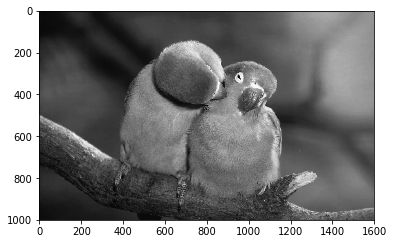

In [12]:
img = np.asarray(Image.open('Sample.jpg').convert('L'))
image = np.copy(img)
plt.imshow(image, cmap = 'gray')
plt.show()

In [13]:
def apply_salt_pepper_noise(image):
    count = 0
    height, width = np.shape(image)
    noise_values = np.array([1.0, 2.0, 3.0, 252.0, 253.0, 254.0], dtype=np.float)
    for h in range(height):
        for w in range(width):
            noise_prob = np.random.rand()
            if noise_prob <= 0.05:
                count+=1
                noise_value = noise_values[int(np.random.rand() * len(noise_values))]
                image[h, w] = noise_value
    print(count)
    return image

80602


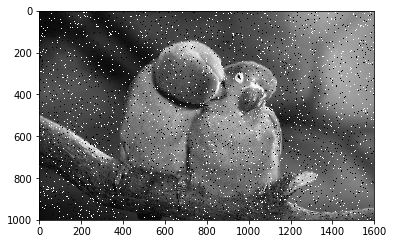

In [14]:
noisy_image = apply_salt_pepper_noise(image)
plt.imshow(noisy_image, cmap='gray')
plt.show()

In [15]:
def median_denoising(image):
    height, width = np.shape(image)
    for h in range(1, height - 1):
        for w in range(1, width - 1):
            neighbours = np.sort([image[h + x, w + y] for x in range(-1, 2) for y in range(-1, 2)])
            image[h, w] = neighbours[4]
    return image
                    

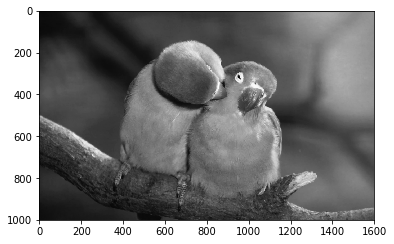

In [16]:
restored_image = median_denoising(noisy_image)
plt.imshow(restored_image, cmap = 'gray')
plt.show()

In [17]:
def mean_denoising(image):
    height, width = np.shape(image)
    for h in range(1, height - 1):
        for w in range(1, width - 1):
            mean = np.mean([image[h + x, w + y] for x in range(-1, 2) for y in range(-1, 2)])
            image[h, w] = mean
    return image

79974


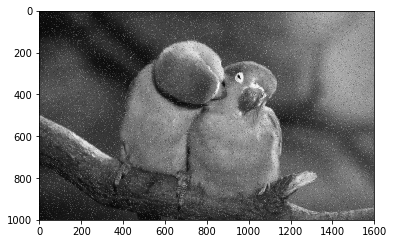

In [18]:
noisy_image = apply_salt_pepper_noise(image)
restored_image = mean_denoising(noisy_image)
plt.imshow(restored_image, cmap = 'gray')
plt.show()

** Now lets apply gaussian noise to the image and see what the image looks like before and after applying the denoising filters **

In [19]:
def apply_gaussian_noise(image):
    height, width = np.shape(image)
    mean = 0
    std_dev = 300 ** 0.5
    gaussian = np.random.normal(mean, std_dev, (height, width))
    noisy_image = gaussian + image
    return noisy_image

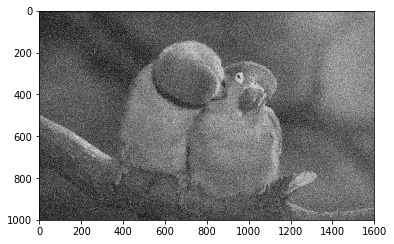

In [20]:
noisy_image = apply_gaussian_noise(image)
plt.imshow(noisy_image, cmap='gray')
plt.show()

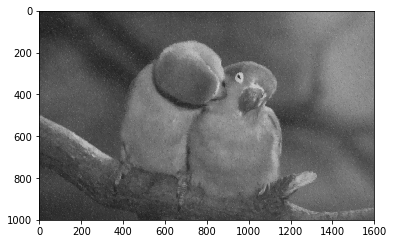

In [21]:
restored_image = median_denoising(noisy_image)
plt.imshow(restored_image, cmap='gray')
plt.show()

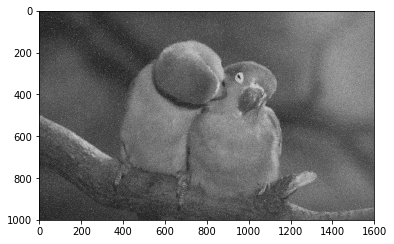

In [22]:
noisy_image = apply_gaussian_noise(image)
restored_image = mean_denoising(noisy_image)
plt.imshow(restored_image, cmap='gray')
plt.show()